In [1]:
from MLpipeline.data_cleaning import build_data_frame
from MLpipeline.s3_data_ingestion import download_data #for when storing data through AWS - Amazon S3 bucket
from MLpipeline.preprocessing import preprocessor
from MLpipeline.train_model import train
from MLpipeline.predict import model_predictions
# from MLpipeline.write_df_to_bucket import writeDF

import numpy as np
import pandas as pd

### Using an S3 bucket with access codes and a bucket location

In [2]:
# df = download_data(access_file='portfolio-access_accessKeys.csv',bucket='portfolio-overview-ns25',object_key='data/nba_totals_agg.csv', region='us-east-1')

In [3]:
df_totals, df_aggregated = build_data_frame("data_files")
df_aggregated.head()

,Player,Age,Year,Tm,Pos,G,GS,MP,FG,FGA,...,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,A.J. Green,23,2024,MIL,SG,35,1,345,53,125,...,4,6,39,45,22,6,0,9,31,154
1,A.J. Green,25,2025,MIL,SG,73,7,1659,182,424,...,27,18,156,174,108,37,7,40,157,541
2,A.J. Lawson,22,2024,DAL,SG,15,0,108,22,44,...,8,6,15,21,2,2,0,3,11,56
3,A.J. Lawson,24,2025,TOR,SG,26,2,486,80,190,...,63,20,66,86,31,13,6,15,44,236
4,AJ Griffin,19,2024,ATL,SF,72,12,1401,248,533,...,47,37,116,153,73,42,12,42,87,639


In [4]:
df_aggregated['3PA'].median()

95.0

In [5]:
df_aggregated['Pos'] = np.where((df_aggregated['Pos'].isin(['PF','SF','SG'])) & (df_aggregated['3PA'] > df_aggregated['3PA'].median()), 'Wing', df_aggregated['Pos'])

In [6]:
df_aggregated['Pos'].value_counts()

Pos
Wing    788
C       424
PG      416
SG      224
PF      205
SF      196
Name: count, dtype: int64

# Total feature and target data with label encoder

X - features - player season statistics

y - target - player position

le - label encoder to label nominal variables as integers

In [7]:
X,y,le = preprocessor(df_aggregated)

In [8]:
model, X_train, y_train, X_val, y_val, X_test, y_test = train(X,y,'xgb_model_wing_big_pos.joblib')

In [9]:
pd.Series(le.inverse_transform(y_test)).value_counts(normalize=True)

Wing    0.563877
C       0.185022
PG      0.185022
PF      0.035242
SF      0.017621
SG      0.013216
Name: proportion, dtype: float64

Predictions saved to: output_wing_big_pos\predictions.csv
Precision (macro): 0.599979198086224
Recall (macro): 0.525421626984127
F1 Score (macro): 0.5526686900272847
Precision (weighted): 0.775967626907138

Classification Report:
               precision    recall  f1-score   support

           C       0.76      0.74      0.75        42
          PF       0.29      0.25      0.27         8
          PG       0.71      0.69      0.70        42
          SF       0.50      0.25      0.33         4
          SG       0.50      0.33      0.40         3
        Wing       0.85      0.89      0.87       128

    accuracy                           0.78       227
   macro avg       0.60      0.53      0.55       227
weighted avg       0.78      0.78      0.78       227



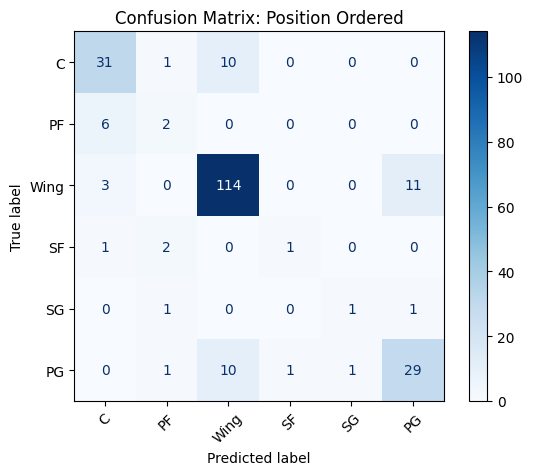

In [10]:
y_proba, predictions_df = model_predictions(model, X_test,y_test,le, save_dir=r'output_wing_big_pos')